# RFM : 고객 세분화 분류

- RFM 거래날짜, 거래빈도, 평균금액으로 고객 분류
    - 충성고객, 신규고객, 잠재고객, 휴먼고객, 이탈고객 등
    
- 고객 세분화 후 각 고객 층마다 적절한 마케팅전략 수립

---

### 사전준비

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# 한글깨짐해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [273]:
df_customer= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Customer_info.csv")
df_sales= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Onlinesales_info.csv")
df_discount= pd.read_csv("C:\\Users\\minu\\lab\\dacon0210\\Discount_info.csv")

df = pd.merge(df_customer, df_sales,how='right',on = '고객ID')

---

### 고객 추출

In [71]:
class customer_tool:
    def __init__(self,df):
        self.df = df
        customer_lst= self.df.groupby('고객ID').count().index.values
        self.customer_lst = customer_lst
    def customer(self,idnum):
        self.dfID = df[df['고객ID'] == self.customer_lst[idnum]]
        return self.dfID

In [124]:
tool = customer_tool(df)

- 가입기간 거래날짜 -> 최근 이용
- 거래 ID -> 거래 빈도
- 평균 금액 -> 이커머스 중요도
- 총 구매기간

### RFM example

`-` 고객 1358의 거래날짜, 거래횟수, 총 거래금액

In [66]:
#print('마지막 거래날짜', tool.customer(1358)['가입기간'][0])
print('최근 거래날짜',tool.customer(1358)['거래날짜'][:1].values)
print('마지막 거래날짜',tool.customer(1358)['거래날짜'][-1:].values)
print('거래횟수',tool.customer(1358).groupby('거래ID').count().shape[0])
print('총 거래 금액',tool.customer(1358)['평균금액'].sum())

최근 거래날짜 ['2019-01-01']
마지막 거래날짜 ['2019-01-26']
거래횟수 177
총 거래 금액 20483.980000000003


`-` 고객 0의 거래날짜, 거래횟수, 총 거래금액

In [67]:
print('최근 거래날짜',tool.customer(0)['거래날짜'][:1].values)
print('마지막 거래날짜',tool.customer(0)['거래날짜'][-1:].values)
print('거래횟수',tool.customer(0).groupby('거래ID').count().shape[0])
print('총 거래 금액',tool.customer(0)['평균금액'].sum())

최근 거래날짜 ['2019-09-15']
마지막 거래날짜 ['2019-09-15']
거래횟수 1
총 거래 금액 25.49


---

### 고객의 거래날짜, 빈도, 금액, 가입기간 추출

-RFM

In [265]:
def f(df):
    a= df['거래날짜'][:1].values.tolist()
    a1=datetime.strptime(a[0], '%Y-%m-%d').strftime('%Y-%m-%d')
    
    b=df['거래날짜'][-1:].values.tolist()
    b2=datetime.strptime(b[0], '%Y-%m-%d').strftime('%Y-%m-%d')
    b3 =df['가입기간'][:1].values
    
    c=df.groupby('거래ID').count().shape[0]
    d=df['평균금액'].sum()
    return a1,b2,float(b3),c,d

In [270]:
RFM_df = pd.DataFrame([f(tool.customer(i)) for i in range(tool.customer_lst.shape[0])])
RFM_df.columns = ['최초거래날짜', '최근거래날짜', '가입기간','거래빈도','거래총금액']
RFM_df['최근거래날짜'] = pd.to_datetime(RFM_df['최근거래날짜'])
RFM_df['최초거래날짜'] = pd.to_datetime(RFM_df['최초거래날짜'])

### 군집분석 변수 관리

- 최근거래날짜, 거래빈도, 총 거래 금액을 이용
- 주의: 총 거래 금액이 수량을 고려하지 않았음
    - 정말 총 거래금액이 맞는지 재고할 필요가 매우 높다
- 대부분의 변수의 분포가 극단적으로 치우쳐저 있으므로 변수변환이 필요해보임

In [349]:
# 201901231에서부터 최근거래날짜의 각 고객의 거리
feature_date= RFM_df['최근거래날짜'] -pd.to_datetime('2019-01-01') 
feature_data1= feature_date.dt.days.values
# 거래빈도
feature_data2=RFM_df['거래빈도'].values
feature_data3=RFM_df['거래총금액'].values

In [350]:
cluster_df= pd.DataFrame({'x1':feature_data1,
             'x2':feature_data2,
             'x3':feature_data3})

`-` data 스케일링

In [351]:
from sklearn.preprocessing import *

minmax = MinMaxScaler()
standard = StandardScaler()
cluster_scale = standard.fit_transform(cluster_df)

`-` model fitting

In [364]:
from sklearn.cluster import KMeans,AgglomerativeClustering

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(cluster_scale)


C:\Users\minu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\minu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


KMeans(n_clusters=5, random_state=0)

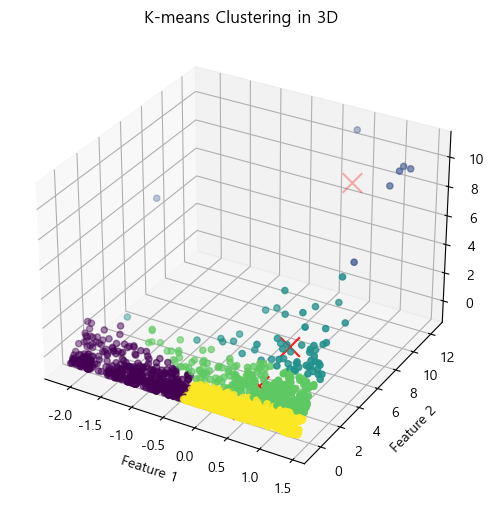

In [365]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# 시각화 (3차원 산점도)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 데이터 포인트 시각화
ax.scatter(cluster_scale[:, 0], cluster_scale[:, 1], cluster_scale[:, 2], c=labels, cmap='viridis')

# 군집 중심 시각화
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker='x', color='red', s=200)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('K-means Clustering in 3D')

plt.show()

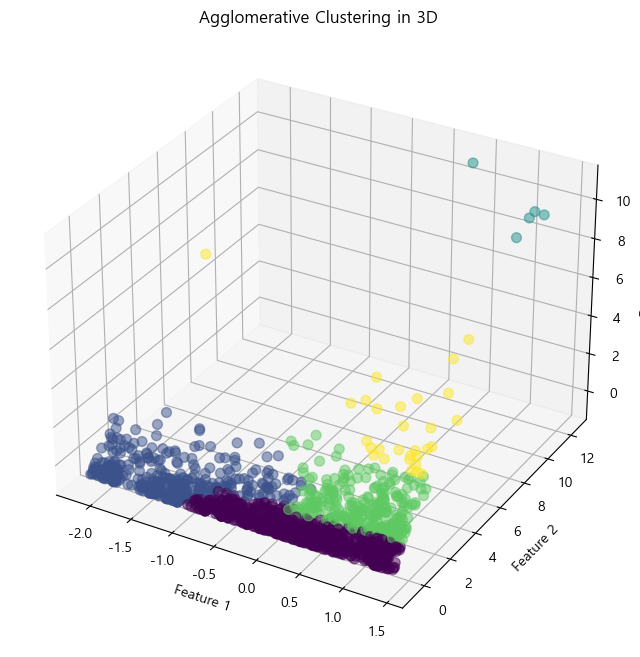

In [366]:
model = AgglomerativeClustering(n_clusters=5)
clusters = model.fit_predict(cluster_scale)

# 결과 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cluster_scale[:, 0], cluster_scale[:, 1], cluster_scale[:, 2], c=clusters, cmap='viridis', s=50, alpha=0.5)
ax.set_title('Agglomerative Clustering in 3D')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.show()